## Плугатирьов Дмитро ІП-15

# Комп'ютерний практикум №1

## Залежності

In [31]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Налаштування виводу на екран

In [32]:
def plot_histogram(values: np.ndarray, bins: int, title: str, color: str = 'blue') -> plt.Axes:
    _, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    ax.set_xlabel('Значення')
    ax.set_ylabel('Частота')
    ax.grid(True)
    ax.hist(values, bins=bins, color=color)
    return ax

def format_mean_std(mean_std: tuple, title):
    mean, std = mean_std
    return f'{title}: \nСереднє: {mean:.3f}, Std: {std:.3f}'

def format_chi2_info(chi2, chi2_k, title):
    return f'{title}: \nChi^2: {chi2:.3f}, Chi^2 k: {chi2_k}'

## Обчислення значень

In [33]:
def get_sturges_bin_count(sample_size: int) -> int:
    """Розраховує оптимальну кількість інтервалів за правилом Стерджеса."""
    return math.ceil(math.log2(sample_size) + 1)

def get_bin_intervals(bin_edges : np.ndarray) -> list[tuple[float, float]]:
    """Перетворює масив меж [0, 5, 10] на пари [(0, 5), (5, 10)]."""
    return list(zip(bin_edges[:-1], bin_edges[1:]))

def calculate_sample_stats(data: np.ndarray) -> tuple[float, float]:
    """Повертає середнє (mean) та стандартне відхилення (std) вибірки."""
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    return (mean, std)

# Chi2 з таблиці (заздалегідь визначена) (функція відсоткової точки - ppf)
def get_chi2_critical_value(alpha: float, num_bins: int, num_params: int) -> float:
    """
    Повертає критичне значення з таблиці розподілу.
    df (degrees of freedom) = кількість інтервалів - кількість оцінених параметрів - 1
    """
    degrees_of_freedom = num_bins - num_params - 1
    return stats.chi2.ppf(1 - alpha, df=degrees_of_freedom)

def calculate_chi2_statistic(
    sample_size: int, 
    observed_counts: np.ndarray, 
    bin_edges: np.ndarray, 
    probability_func: callable, 
    *dist_params
    ) -> float:
    intervals = zip(bin_edges[:-1], bin_edges[1:])
    expected_probs = np.array([probability_func(l, r, *dist_params) for l, r in intervals])

    expected_counts = sample_size * expected_probs
    # Захист від ділення на 0 (хоча при рівноймовірних інтервалах це малоймовірно)
    expected_counts[expected_counts == 0] = 1e-10
    
    chi2 = np.sum(np.square(observed_counts - expected_counts) / expected_counts)
    return chi2

def is_hypothesis_accepted(chi2_stat: float, critical_value: float) -> bool:
    return chi2_stat <= critical_value

# Експоненційний закон розподілу


>>> ТЕСТУВАННЯ ДЛЯ LAMBDA = 0.5
Оцінене lambda: 0.5042 (Задане: 0.5)
Chi2 статистика: 8.3842
Критичне значення (df=7): 14.0671
Результат: Закон ПІДТВЕРДЖЕНО
Експоненціальний (λ=0.5): 
Середнє: 1.983, Std: 1.984

>>> ТЕСТУВАННЯ ДЛЯ LAMBDA = 1.0
Оцінене lambda: 1.0048 (Задане: 1.0)
Chi2 статистика: 8.2070
Критичне значення (df=10): 18.3070
Результат: Закон ПІДТВЕРДЖЕНО
Експоненціальний (λ=1.0): 
Середнє: 0.995, Std: 1.009

>>> ТЕСТУВАННЯ ДЛЯ LAMBDA = 2.5
Оцінене lambda: 2.4814 (Задане: 2.5)
Chi2 статистика: 6.6737
Критичне значення (df=11): 19.6751
Результат: Закон ПІДТВЕРДЖЕНО
Експоненціальний (λ=2.5): 
Середнє: 0.403, Std: 0.402

>>> ТЕСТУВАННЯ ДЛЯ LAMBDA = 5.0
Оцінене lambda: 4.8679 (Задане: 5.0)
Chi2 статистика: 7.6093
Критичне значення (df=9): 16.9190
Результат: Закон ПІДТВЕРДЖЕНО
Експоненціальний (λ=5.0): 
Середнє: 0.205, Std: 0.206


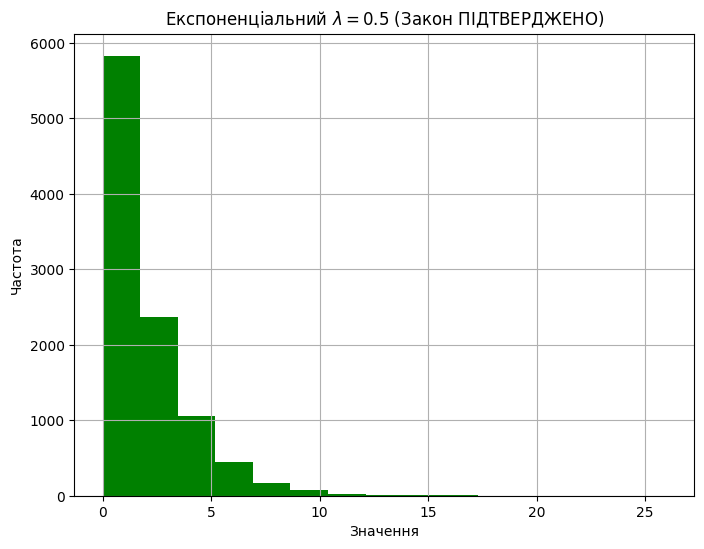

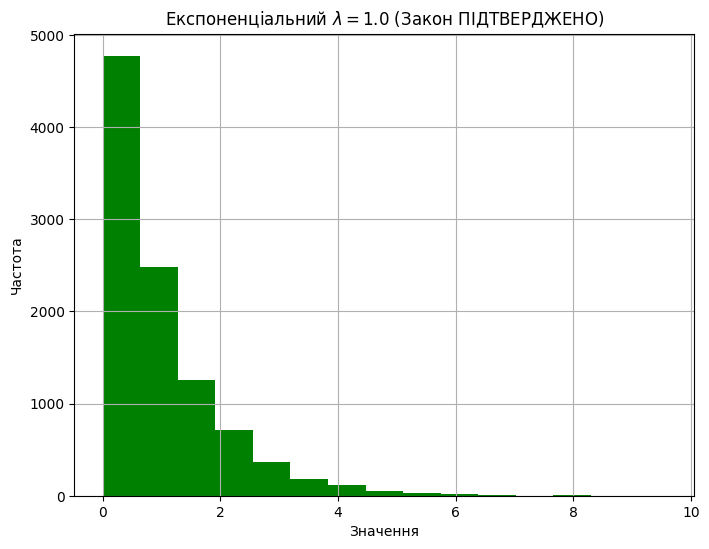

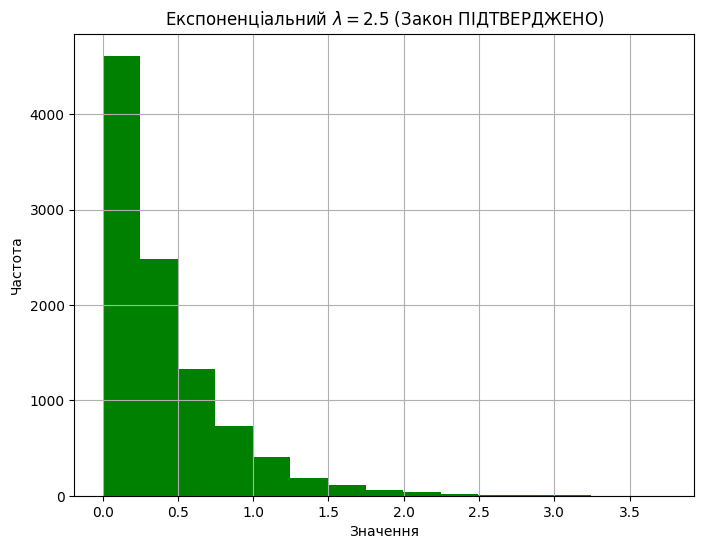

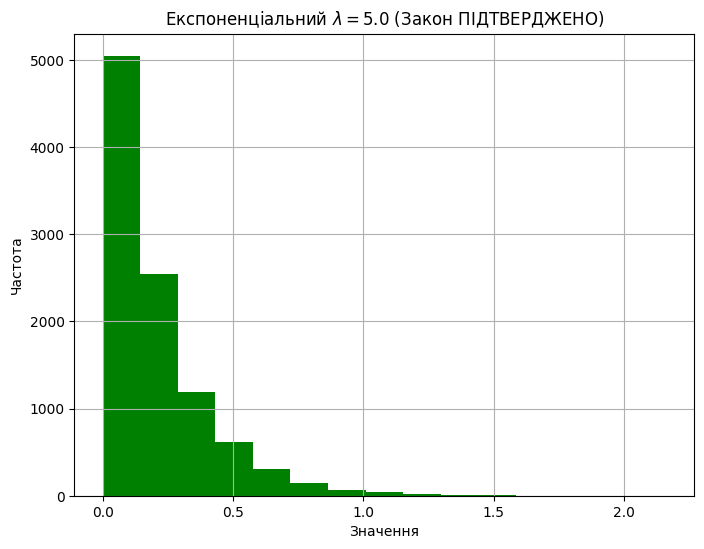

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# 1. ФУНКЦІЯ ПЕРЕВІРКИ (Об'єднує генерацію та тест)
def test_exponential_hypothesis(target_lambda, sample_size):
    print("\n" + "="*50)
    print(f">>> ТЕСТУВАННЯ ДЛЯ LAMBDA = {target_lambda}")
    print("="*50)

    # --- А. Генерація вибірки (Формула з завдання) ---
    uniform_samples = np.random.uniform(size=sample_size)
    exponential_samples = -1 / target_lambda * np.log(uniform_samples)

    # Розрахунок кількості бінів
    num_bins = get_sturges_bin_count(sample_size) 

    # --- Б. Отримання гістограми та оцінка параметрів ---
    observed_counts, bin_edges = np.histogram(exponential_samples, bins=num_bins)
    
    # Оцінюємо лямбда з вибірки (для чистоти експерименту)
    # Хоча ми знаємо target_lambda, тест Хі-квадрат зазвичай використовує оцінений параметр
    estimated_lambda = 1 / np.mean(exponential_samples)
    n_samples = len(exponential_samples)
    
    # --- В. Розрахунок теоретичних частот ---
    raw_expected = []
    for i in range(len(bin_edges) - 1):
        a = bin_edges[i]
        b = bin_edges[i+1]
        # P(a <= X < b) = exp(-lam*a) - exp(-lam*b)
        prob = np.exp(-estimated_lambda * a) - np.exp(-estimated_lambda * b)
        raw_expected.append(prob * n_samples)

    # --- Г. Об'єднання малих інтервалів (Ваш алгоритм) ---
    final_obs = []
    final_exp = []
    current_o = 0
    current_e = 0

    for o, e in zip(observed_counts, raw_expected):
        current_o += o
        current_e += e
        if current_e >= 5:
            final_obs.append(current_o)
            final_exp.append(current_e)
            current_o = 0
            current_e = 0
            
    if current_e > 0:
        if len(final_exp) > 0:
            final_obs[-1] += current_o
            final_exp[-1] += current_e
        else:
            final_obs.append(current_o)
            final_exp.append(current_e)

    final_obs = np.array(final_obs)
    final_exp = np.array(final_exp)

    # --- Д. Розрахунок статистики Хі-квадрат ---
    chi2_stat = np.sum((final_obs - final_exp)**2 / final_exp)
    df = len(final_obs) - 1 - 1 # (кількість груп - 1 - кількість параметрів)

    # --- Е. Критичне значення ---
    limit = stats.chi2.ppf(0.95, df)

    # --- Є. Вивід результатів ---
    print(f"Оцінене lambda: {estimated_lambda:.4f} (Задане: {target_lambda})")
    print(f"Chi2 статистика: {chi2_stat:.4f}")
    print(f"Критичне значення (df={df}): {limit:.4f}")
    
    result_msg = "Закон ПІДТВЕРДЖЕНО" if chi2_stat < limit else "Закон ВІДХИЛЕНО"
    print(f"Результат: {result_msg}")

    # Виклик ваших функцій для статистики (якщо вони визначені)
    try:
        estats = calculate_sample_stats(exponential_samples)
        print(format_mean_std(estats, f'Експоненціальний (λ={target_lambda})'))
    except NameError:
        pass # Ігноруємо, якщо функції не знайдено

    # --- Ж. Побудова графіка ---
    plot_title = f'Експоненціальний $\\lambda={target_lambda}$ ({result_msg})'
    plot_histogram(
        exponential_samples, 
        num_bins, 
        title=plot_title, 
        color='green' if chi2_stat < limit else 'red'
    )

# ==========================================
# 2. ГОЛОВНИЙ ЦИКЛ (Виконання завдання)
# ==========================================

sample_size_global = 10000 
# Список різних лямбда для перевірки, як вимагає завдання
lambda_values_to_test = [0.5, 1.0, 2.5, 5.0]

for lam in lambda_values_to_test:
    test_exponential_hypothesis(target_lambda=lam, sample_size=sample_size_global)

# Нормальний закон розподілу


>>> ТЕСТУВАННЯ: a (Mean) = 0, sigma (Std) = 1
Оцінені параметри: Mean=0.0077, Std=1.0026
Chi2 статистика: 5.4184
Критичне значення (df=10): 18.3070
Результат: Закон ПІДТВЕРДЖЕНО

>>> ТЕСТУВАННЯ: a (Mean) = -5, sigma (Std) = 4
Оцінені параметри: Mean=-5.0344, Std=3.9883
Chi2 статистика: 15.1205
Критичне значення (df=12): 21.0261
Результат: Закон ПІДТВЕРДЖЕНО

>>> ТЕСТУВАННЯ: a (Mean) = 10, sigma (Std) = 2
Оцінені параметри: Mean=10.0090, Std=1.9801
Chi2 статистика: 11.7931
Критичне значення (df=12): 21.0261
Результат: Закон ПІДТВЕРДЖЕНО

>>> ТЕСТУВАННЯ: a (Mean) = 100, sigma (Std) = 15
Оцінені параметри: Mean=100.2051, Std=14.8971
Chi2 статистика: 10.4137
Критичне значення (df=11): 19.6751
Результат: Закон ПІДТВЕРДЖЕНО


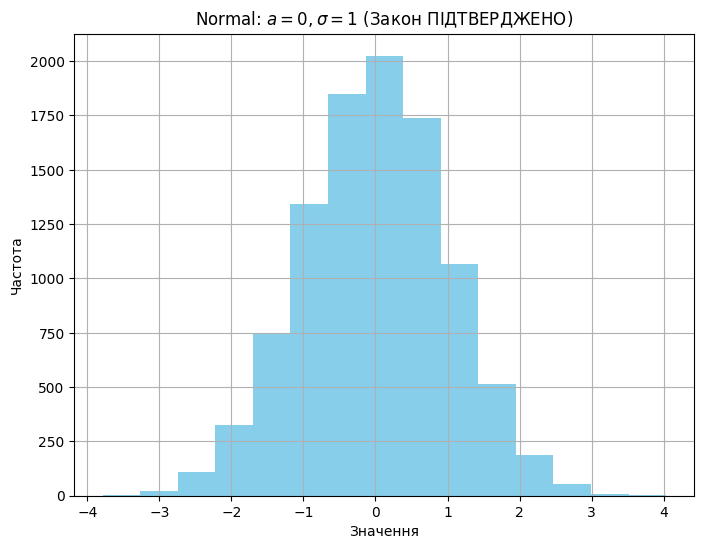

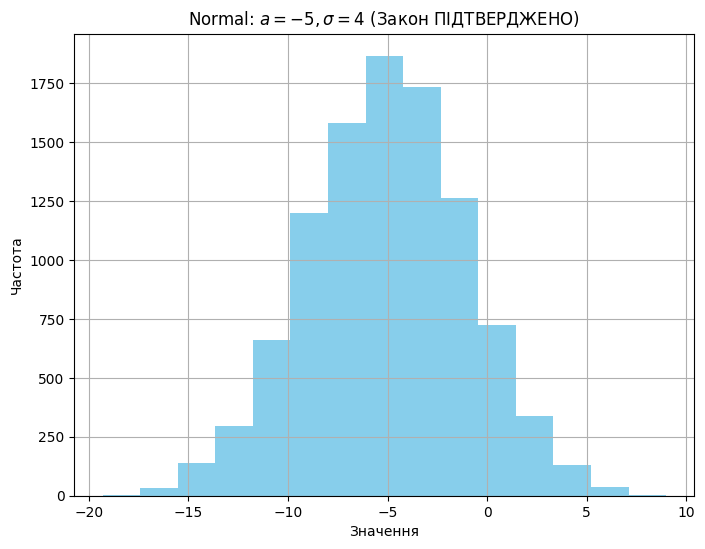

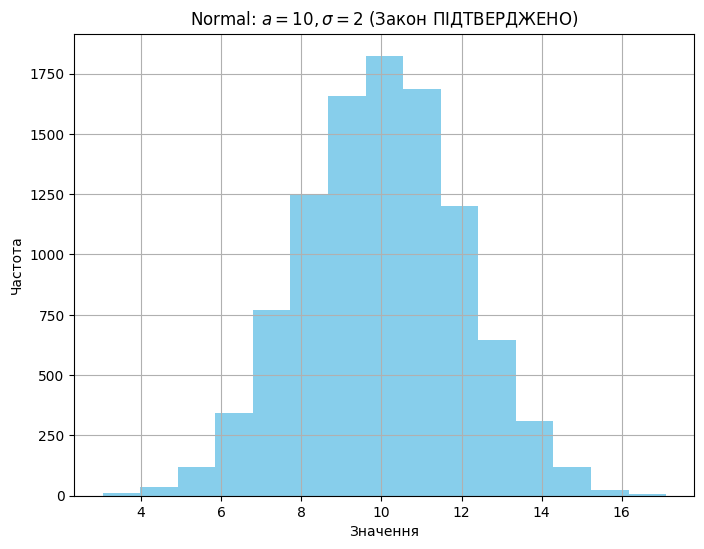

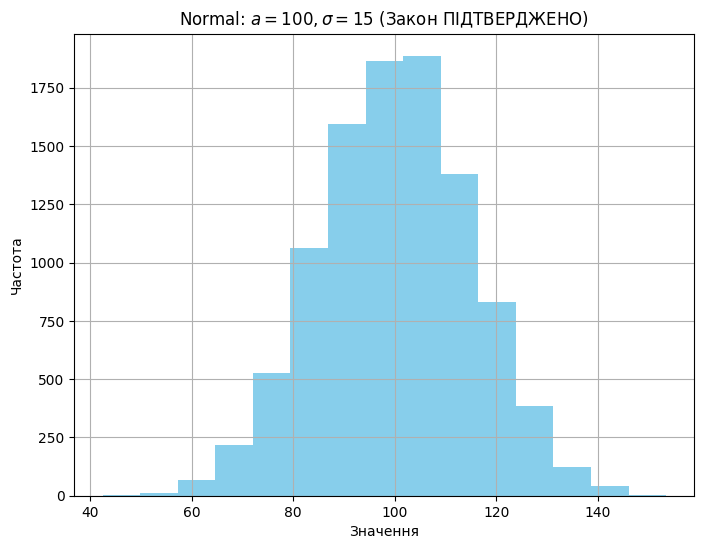

In [35]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# 1. ФУНКЦІЯ ПЕРЕВІРКИ ДЛЯ НОРМАЛЬНОГО РОЗПОДІЛУ
def test_normal_hypothesis(target_mean, target_std, sample_size):
    print("\n" + "="*60)
    print(f">>> ТЕСТУВАННЯ: a (Mean) = {target_mean}, sigma (Std) = {target_std}")
    print("="*60)

    # --- А. Генерація вибірки (Метод з завдання: сума 12 рівномірних) ---
    # 1. Матриця N x 12
    uniform_matrix = np.random.uniform(size=(sample_size, 12))
    
    # 2. Сума - 6 (наближення до N(0,1))
    standard_normals = uniform_matrix.sum(axis=1) - 6
    
    # 3. Трансформація до N(a, sigma)
    normal_data = target_std * standard_normals + target_mean

    # Розрахунок кількості бінів
    num_bins = get_sturges_bin_count(sample_size)

    # --- Б. Отримання гістограми та оцінка параметрів ---
    observed_counts, bin_edges = np.histogram(normal_data, bins=num_bins)
    
    # Оцінюємо параметри з вибірки (для тесту Хі-квадрат це стандарт)
    estimated_mean = np.mean(normal_data)
    estimated_std = np.std(normal_data)
    n_samples = len(normal_data)

    # --- В. Розрахунок теоретичних частот (через CDF) ---
    raw_expected = []
    for i in range(len(bin_edges) - 1):
        left = bin_edges[i]
        right = bin_edges[i+1]
        
        # Площа під кривою Гауса між межами біна
        prob = stats.norm.cdf(right, loc=estimated_mean, scale=estimated_std) - \
               stats.norm.cdf(left, loc=estimated_mean, scale=estimated_std)
        
        raw_expected.append(prob * n_samples)

    # --- Г. Об'єднання малих інтервалів (Критично важливо) ---
    final_obs = []
    final_exp = []
    current_o = 0
    current_e = 0

    for o, e in zip(observed_counts, raw_expected):
        current_o += o
        current_e += e
        # Накопичуємо, поки очікувана частота не стане >= 5
        if current_e >= 5:
            final_obs.append(current_o)
            final_exp.append(current_e)
            current_o = 0
            current_e = 0
            
    # Обробка залишку
    if current_e > 0:
        if len(final_exp) > 0:
            final_obs[-1] += current_o
            final_exp[-1] += current_e
        else:
            final_obs.append(current_o)
            final_exp.append(current_e)

    final_obs = np.array(final_obs)
    final_exp = np.array(final_exp)

    # --- Д. Розрахунок статистики Хі-квадрат ---
    chi2_stat = np.sum((final_obs - final_exp)**2 / final_exp)
    
    # Ступені свободи: k - 1 - m (де m=2 параметри: mean, std)
    df = len(final_obs) - 1 - 2 

    # --- Е. Критичне значення ---
    limit = stats.chi2.ppf(0.95, df)

    # --- Є. Вивід результатів ---
    print(f"Оцінені параметри: Mean={estimated_mean:.4f}, Std={estimated_std:.4f}")
    print(f"Chi2 статистика: {chi2_stat:.4f}")
    print(f"Критичне значення (df={df}): {limit:.4f}")
    
    if chi2_stat < limit:
        result_msg = "Закон ПІДТВЕРДЖЕНО"
        plot_color = 'skyblue'
    else:
        result_msg = "Закон ВІДХИЛЕНО"
        plot_color = 'orange'
    print(f"Результат: {result_msg}")

    # --- Ж. Побудова графіка ---
    plot_title = f'Normal: $a={target_mean}, \\sigma={target_std}$ ({result_msg})'
    plot_histogram(
        normal_data, 
        bin_edges, # Оригінальні межі для візуалізації
        title=plot_title, 
        color=plot_color
    )

# ==========================================
# 2. ГОЛОВНИЙ ЦИКЛ (Виконання завдання)
# ==========================================

sample_size_global = 10000

# Список параметрів для перевірки [(mean, std), (mean, std), ...]
# Завдання вимагає "різних значень a і sigma"
params_to_test = [
    (0, 1),    # Стандартний нормальний
    (-5, 4),   # Ваші початкові значення
    (10, 2),   # Зміщене з меншим розкидом
    (100, 15)  # Великі значення
]

for mean_val, std_val in params_to_test:
    test_normal_hypothesis(target_mean=mean_val, target_std=std_val, sample_size=sample_size_global)

# Рівномірний закон розподілу


>>> ТЕСТУВАННЯ LCG: a = 1220703125, c = 2147483648
Кількість бінів: 15
Chi2 статистика: 12.9800
Критичне значення (df=14): 23.6848
Результат: Генератор ЯКІСНИЙ (Рівномірний)

>>> ТЕСТУВАННЯ LCG: a = 106, c = 6075
Кількість бінів: 15
Chi2 статистика: 0.1520
Критичне значення (df=14): 23.6848
Результат: Генератор ЯКІСНИЙ (Рівномірний)

>>> ТЕСТУВАННЯ LCG: a = 5, c = 17
Кількість бінів: 15
Chi2 статистика: 546.8750
Критичне значення (df=14): 23.6848
Результат: Генератор ПОГАНИЙ (Нерівномірний)

>>> ТЕСТУВАННЯ LCG: a = 22695477, c = 4294967296
Кількість бінів: 15
Chi2 статистика: 16.3640
Критичне значення (df=14): 23.6848
Результат: Генератор ЯКІСНИЙ (Рівномірний)


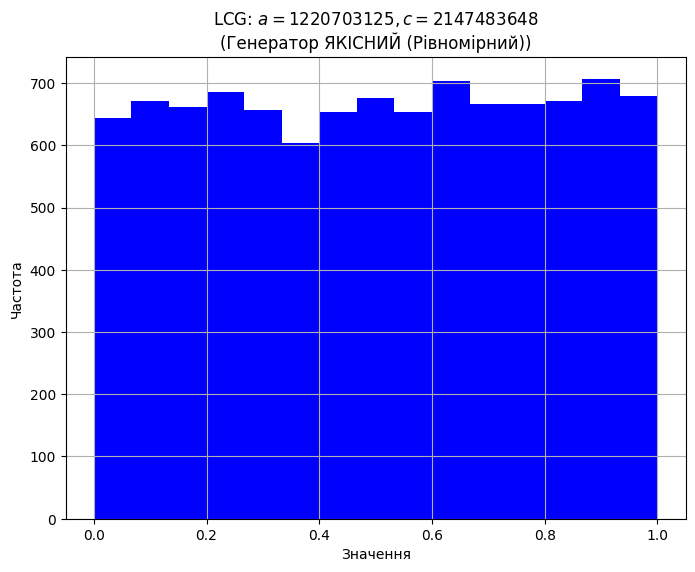

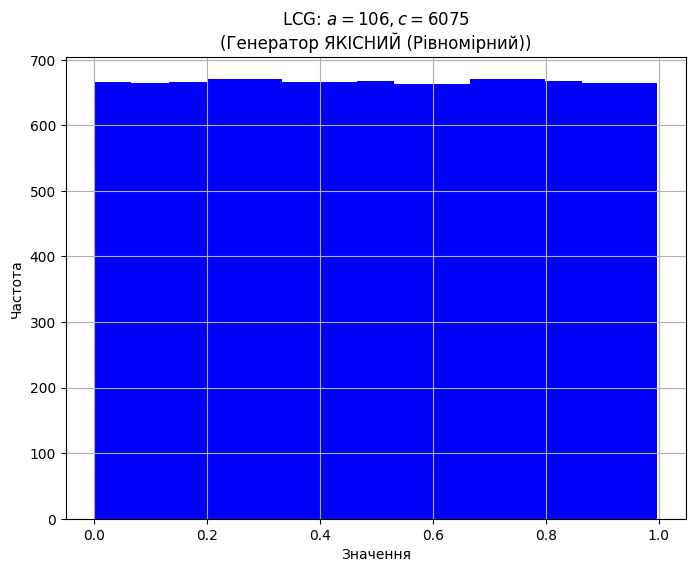

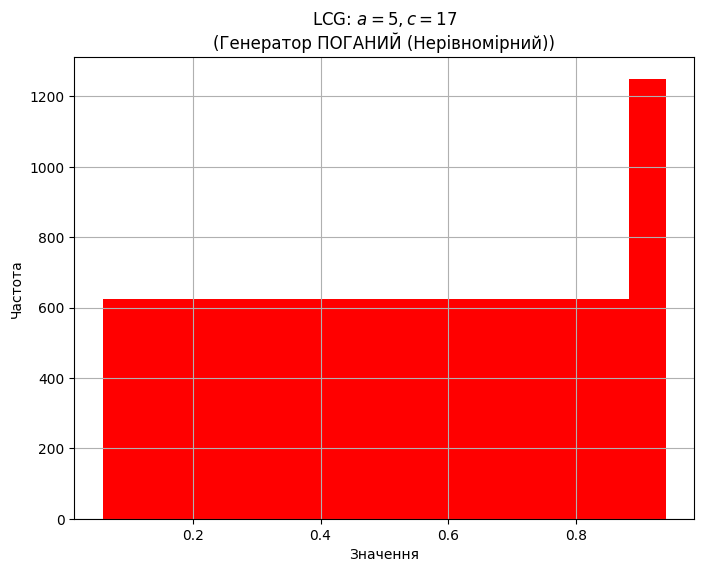

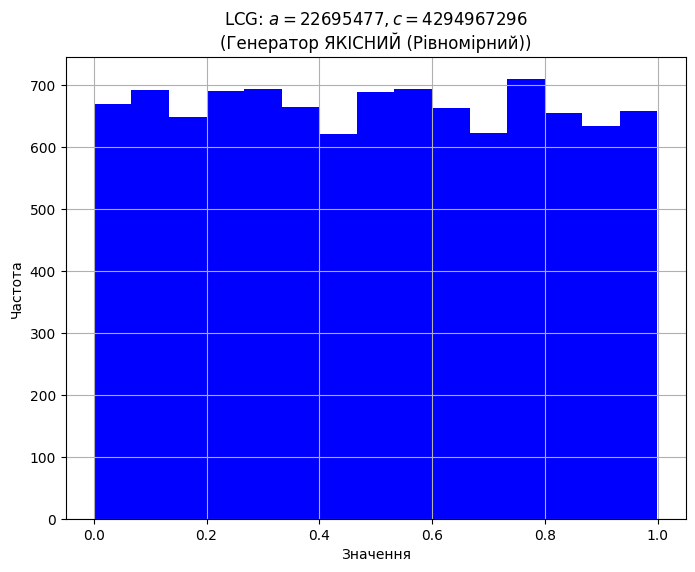

In [36]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# 1. ФУНКЦІЯ: ГЕНЕРАТОР LCG + ПЕРЕВІРКА ХІ-КВАДРАТ
def test_lcg_uniformity(a_param, c_param, sample_size):
    print("\n" + "="*60)
    print(f">>> ТЕСТУВАННЯ LCG: a = {a_param}, c = {c_param}")
    print("="*60)

    # --- А. Генерація чисел методом LCG (Linear Congruential Generator) ---
    # Формула: z_{i+1} = (a * z_i) mod c
    #          x_i = z_i / c
    
    uniform_data = np.zeros(sample_size)
    
    # Початкове значення (Seed). Важливо, щоб z0 != 0
    # Беремо 1 або середину інтервалу, якщо c велике
    current_z = 1 
    
    # Генеруємо цикл (Python справляється з великими цілими числами автоматично)
    for i in range(sample_size):
        current_z = (a_param * current_z) % c_param
        uniform_data[i] = current_z / c_param

    # --- Б. Визначення кількості інтервалів ---
    # Використовуємо формулу Стерджеса
    num_bins = get_sturges_bin_count(sample_size)

    # --- В. Отримання гістограми ---
    observed_counts, bin_edges = np.histogram(uniform_data, bins=num_bins, range=(0, 1))
    
    # --- Г. Теоретичні частоти ---
    # Для рівномірного розподілу в [0, 1] ймовірність попадання в бін = ширина біна.
    # E_i = N * (width / 1.0)
    
    n_samples = len(uniform_data)
    raw_expected = []
    
    for i in range(len(bin_edges) - 1):
        width = bin_edges[i+1] - bin_edges[i]
        prob = width 
        raw_expected.append(prob * n_samples)

    # --- Д. Об'єднання малих інтервалів (Safety check) ---
    final_obs = []
    final_exp = []
    current_o = 0
    current_e = 0

    for o, e in zip(observed_counts, raw_expected):
        current_o += o
        current_e += e
        if current_e >= 5:
            final_obs.append(current_o)
            final_exp.append(current_e)
            current_o = 0
            current_e = 0
            
    if current_e > 0:
        if len(final_exp) > 0:
            final_obs[-1] += current_o
            final_exp[-1] += current_e
        else:
            final_obs.append(current_o)
            final_exp.append(current_e)

    final_obs = np.array(final_obs)
    final_exp = np.array(final_exp)

    # --- Е. Розрахунок Хі-квадрат ---
    # Додаємо epsilon, щоб уникнути ділення на нуль у випадку виродженого генератора
    chi2_stat = np.sum((final_obs - final_exp)**2 / (final_exp + 1e-10))
    
    # Ступені свободи: k - 1
    df = len(final_obs) - 1

    # Критичне значення
    limit = stats.chi2.ppf(0.95, df)

    # --- Є. Вивід результатів ---
    print(f"Кількість бінів: {len(final_obs)}")
    print(f"Chi2 статистика: {chi2_stat:.4f}")
    print(f"Критичне значення (df={df}): {limit:.4f}")
    
    if chi2_stat < limit:
        result_msg = "Генератор ЯКІСНИЙ (Рівномірний)"
        plot_color = 'blue'
    else:
        result_msg = "Генератор ПОГАНИЙ (Нерівномірний)"
        plot_color = 'red'
    print(f"Результат: {result_msg}")

    # --- Ж. Графік ---
    plot_title = f'LCG: $a={a_param}, c={c_param}$\n({result_msg})'
    
    try:
        plot_histogram(uniform_data, num_bins, title=plot_title, color=plot_color)
    except NameError:
        plt.figure(figsize=(10, 4))
        plt.hist(uniform_data, bins=num_bins, range=(0,1), color=plot_color, edgecolor='black', alpha=0.7)
        plt.title(plot_title)
        plt.show()

# ==========================================
# 2. ЗАПУСК ДЛЯ РІЗНИХ ПАРАМЕТРІВ a і c
# ==========================================
sample_size_global = 10000

# Список тестових параметрів (a, c)
# Згідно із завданням, перевіряємо різні варіанти
lcg_params = [
    (5**13, 2**31),  # 1. Еталонний варіант із завдання (Має пройти ✅)
    (106, 6075),     # 2. Простий приклад (Може бути OK або ні)
    (5, 17),         # 3. Дуже малий модуль (Має провалити тест ❌ - мало унікальних значень)
    (22695477, 2**32)# 4. Реалізація Borland C/C++ (Історичний стандарт, має пройти ✅)
]

for a_val, c_val in lcg_params:
    test_lcg_uniformity(a_param=a_val, c_param=c_val, sample_size=sample_size_global)